In [46]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pylab
import scipy.stats as stats
import seaborn as sns
from functools import partial
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

In [66]:
orig_data = pd.read_csv('day.csv')
orig_data["atemp_actual"] = orig_data["atemp"] * 50
orig_data.head(5)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,atemp_actual
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985,18.18125
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801,17.68695
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349,9.47025
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562,10.60610
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600,11.46350


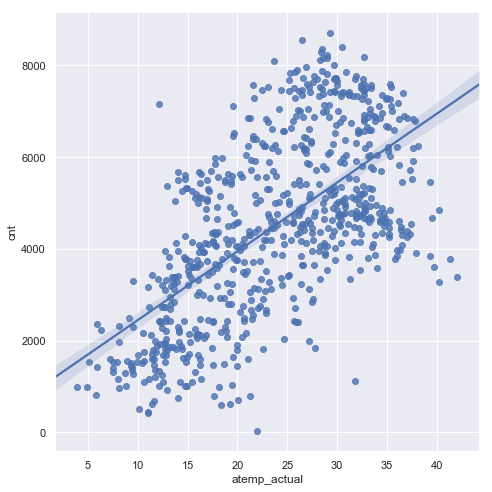

In [67]:
sns.set(color_codes=True)
filtered_df = orig_data
sns.lmplot(x="atemp_actual", y="cnt", height=7, data=filtered_df);

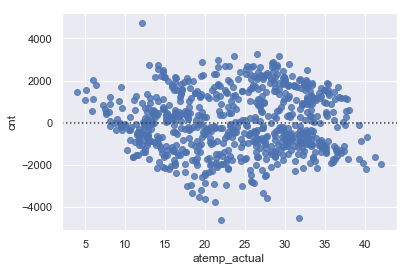

In [70]:
sns.residplot(x="atemp_actual", y="cnt", data=filtered_df, order=2);

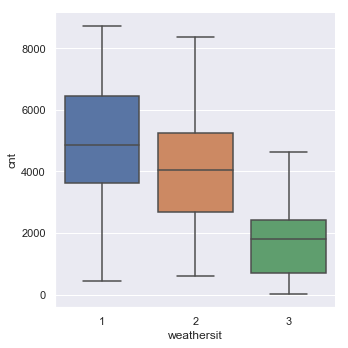

In [64]:
sns.catplot(x="workingday", y="cnt", kind="box", data=filtered_d);

In [31]:
x = filtered_df["Size"]
y = filtered_df["Baths"]
np.corrcoef(x, y)[0][1]

0.7437590948697624

In [37]:
def get_all_X_columns(df):
    return df[["atemp"]]

def get_X_columns(df):
    return df[["atemp"]]

def get_Y_column(df):
    return df["cnt"]

In [38]:
def get_XY(data, X_columns_func=get_all_X_columns):
    X = X_columns_func(data).values
    Y = get_Y_column(data).values
    return X, Y

In [50]:
def get_model(X_train, Y_train):
    model = Pipeline([('poly', PolynomialFeatures(degree=1, interaction_only=True)),
                      ('linear', LinearRegression(fit_intercept=False))])
    model.fit(X_train, Y_train)
    return model

In [40]:
def get_errors(Y_train, Y_train_pred, Y_test, Y_test_pred):    
    training_rmse = math.sqrt(mean_squared_error(Y_train_pred, Y_train))
    test_rmse = math.sqrt(mean_squared_error(Y_test_pred, Y_test))
    training_rsq = r2_score(Y_train_pred, Y_train)
    test_rsq = r2_score(Y_test_pred, Y_test)
    return training_rmse, test_rmse, training_rsq, test_rsq

In [41]:
def plot_feature_weights(coef, X_columns_func=get_all_X_columns):
    features = X_columns_func(orig_data).columns.values
    weights = coef
    plt.bar(features, weights)
    for a,b in zip(features, weights):
        plt.text(a, b, "{0:.2f}".format(b))
    plt.show()

In [48]:
## Fitting attempt 1
X_train, Y_train = get_XY(filtered_df)
model = get_model(X_train, Y_train)
#plot_feature_weights(model.coef_)
orig_data['predicted']=model.predict(get_all_X_columns(orig_data))
orig_data['residual']=orig_data['predicted'] - get_Y_column(orig_data)

In [38]:
def f_test(X_train, Y_train):
    f_scores = []
    p_values = []
    num_columns = X_train.shape[1]
    deg_freedom = Y_train.shape[0] - num_columns - 1
    
    model_p1 = get_model(X_train, Y_train)
    Y_pred_p1 = model_p1.predict(X_train)
    rss_p1 = mean_squared_error(Y_pred_p1, Y_train)
    
    for col_id in range(0, num_columns):
        X_train_p0 = np.delete(X_train, col_id, 1)
        model_p0 = get_model(X_train_p0, Y_train)
        Y_pred_p0 = model_p0.predict(X_train_p0)
        rss_p0 = mean_squared_error(Y_pred_p0, Y_train)
        
        f_score = (rss_p0 - rss_p1) * deg_freedom / rss_p1
        p_value = 1 - stats.f.cdf(f_score, 1, deg_freedom)
        f_scores.append(f_score)
        p_values.append(p_value)
        
    return f_scores, p_values

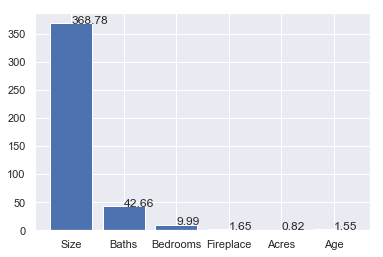

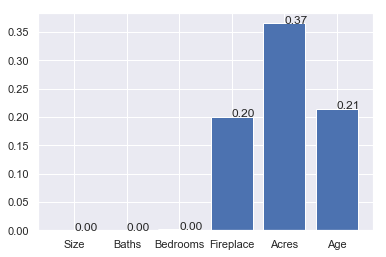

In [39]:
f, p = f_test(X_train, Y_train)
plot_feature_weights(f)
plot_feature_weights(p)

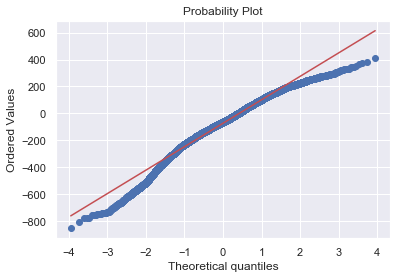

In [51]:
# Q-Q Plot
stats.probplot(orig_data['residual'], dist="norm", plot=pylab)
pylab.show()

The above Q-Q plot implies that there are outliers in the data, both in the negative side (y_actual is much less than y_pred) and on the positive side (y_actual is much higher than y_pred).

In [41]:
orig_data[(orig_data.residual < -200) | (orig_data.residual > 150)]

,Price,Size,Baths,Bedrooms,Fireplace,Acres,Age,predicted,residual
55,79.893,2.634,2.5,4,0,0.24,83,234.170173,154.277173
102,59.003,3.285,2.0,5,0,0.42,233,255.430345,196.427345
375,300.931,0.847,1.0,2,0,0.55,78,72.089267,-228.841733
408,738.919,4.372,5.0,7,1,0.68,144,411.281935,-327.637065
421,763.931,4.390,3.5,4,1,0.40,2,410.363646,-353.567354
422,882.341,5.632,5.5,4,1,5.88,2,570.691333,-311.649667
429,476.301,2.986,2.5,4,1,2.37,12,275.733677,-200.567323
545,155.713,3.535,3.0,4,1,4.20,39,334.059676,178.346676
649,74.422,2.708,2.0,4,0,1.20,21,233.213235,158.791235
723,473.938,0.780,1.5,2,0,0.19,55,80.150630,-393.787370


In [42]:
def cross_validate_error(model_builder):
    sum_train_error = 0
    sum_test_error = 0
    sum_train_rsq = 0
    sum_test_rsq = 0

    splits = 5
    kf = KFold(n_splits=splits)
    for train_indices, test_indices in kf.split(orig_data):
        data_train = orig_data.iloc[train_indices]
        data_test = orig_data.iloc[test_indices]
        #print ("Training, test data shape:", data_train.shape, data_test.shape)
    
        X_data_train, Y_data_train = get_XY(data_train, get_X_columns)
        model = model_builder(X_data_train, Y_data_train)
        #plot_feature_weights(model.coef_, get_X_columns)
    
        X_train, Y_train = get_XY(data_train, get_X_columns)
        X_test, Y_test = get_XY(data_test, get_X_columns)
        Y_train_pred, Y_test_pred = model.predict(X_train), model.predict(X_test)
        training_rmse, test_rmse, training_rsq, test_rsq = \
        get_errors(Y_train, Y_train_pred, Y_test, Y_test_pred)
    
        sum_train_error += training_rmse
        sum_test_error += test_rmse
        sum_train_rsq += training_rsq
        sum_test_rsq += test_rsq   

    #print(sum_train_error/splits, sum_test_error/splits, sum_train_rsq/splits, sum_test_rsq/splits)
    return (sum_test_error/splits)

In [43]:
cross_validate_error(get_model)

52.29905609110509

In [44]:
def get_ridge_model(X_train, Y_train, alpha):
    #print ("Ridge model with alpha: ", alpha)
    model = Ridge(alpha=alpha)
    model.fit(X_train, Y_train)
    return model

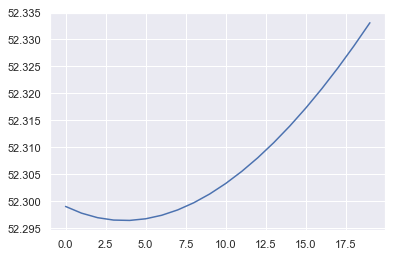

In [45]:
plt.plot([x for x in range(0, 20)], [cross_validate_error(partial(get_ridge_model, alpha=y)) for y in range(0, 20)])
plt.show()

In [46]:
def get_lasso_model(X_train, Y_train, alpha):
    #print ("Ridge model with alpha: ", alpha)
    model = Ridge(alpha=alpha)
    model.fit(X_train, Y_train)
    return model

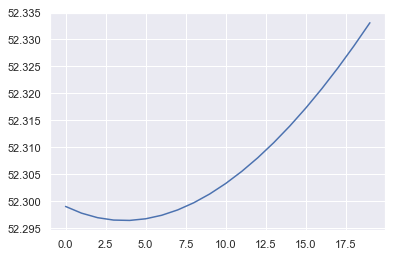

In [47]:
plt.plot([x for x in range(0, 20)], [cross_validate_error(partial(get_lasso_model, alpha=y)) for y in range(0, 20)])
plt.show()